In [4]:
# preparing data

cancer = pd.read_csv("C:/Users/DELL/Downloads/Cancer_Data.csv")
cancer1 = cancer.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(cancer1)) #scaling the data
pca = PCA(n_components = 6)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PC4','PC5','PC6'])
data_pca['output'] = cancer['diagnosis']
data_pca.output[data_pca.output == 'M'] = 1
data_pca.output[data_pca.output == 'B'] = 0
scaler = MinMaxScaler()
cancer_data = scaler.fit_transform(data_pca)
X = cancer_data[:, 0:6]
Y = cancer_data[:,6]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

C:\Users\DELL\AppData\Local\Temp\ipykernel_6888\785812838.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pca.output[data_pca.output == 'M'] = 1
C:\Users\DELL\AppData\Local\Temp\ipykernel_6888\785812838.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pca.output[data_pca.output == 'B'] = 0


The code we're about to make would perform parameterized operations on a vector of some input information (just like a NN). So the first part should be to formulate a way to store that information in some container. The given dataset has 6 features (We've reduced it to 6 features to make the demonstration easy). We need one subcontainer to represent each feature. Classicaly, each container would have multiple bits to represent the input number. Each classical bit has a state $|\psi\rangle$ that can be represented as:
$$ |\psi\rangle = p|0\rangle + (1-p)|1\rangle $$
Here, if p = 0, then the state of the bit is, $$ |\psi\rangle = |1\rangle $$ Generally, we call it the 'on' state. Else, if p = 1, then the state of the bit is, $$ |\psi\rangle = |0\rangle $$ It is called the 'off' state. The sum of coefficients in the above equation is 1.
For a subcontainer to represent a decimal number using the binary system, we generally use multiple bits. We claim that we can do it using a newly defined bit. $$ |\psi\rangle = cos\frac{\theta}{2}|0\rangle + sin\frac{\theta}{2}|1\rangle $$
We call it a qubit. By the nature of sine and cosine functions, it is capable of representing any number between 0 and 1 and capable of being in a combination of fractional $|0\rangle$ and $|1\rangle$ states, a combination of partial on and off states. So, putting just a single qubit in a subcontainer should do the job. 6 such subcontainers should do the job for us. For a subcontainer, which we will now call a qubit, to represent a number, we shall first notice that the sum of squares the coefficient is 1. If we want a qubit to represent a number, say $\frac{3}{4}$, then our qubit sould be in a '$\frac{3}{4}$'-'on' state. Hence, it should be in '$\frac{1}{4}$'-'off' state. Since $ sin^2\frac{\theta}{2} + cos^2\frac{\theta}{2} = 1 $, we require the sine component to take up the responsibility to represent the 'on' state. That is, $ sin^2\frac{\theta}{2} = \frac{3}{4} $ and $ cos^2\frac{\theta}{2} = \frac{1}{4} $. It is clear that the state $ |\psi\rangle $ is a $ \theta $ dependent state, so quite naturally we can say that $ \theta = 2sin^{-1}\frac{\sqrt{3}}{2} $. 

We hereby conclude that whatever value, say p, has to be represented by the qubit, can be mapped to an angle theta by the following relation. $$ \theta = 2sin^{-1}(\sqrt{p}) $$ So lets start with defining a function to map the desired input to an angle which can represent the state of a qubit.

In [5]:
# importing the required functions
from math import asin, sqrt

def val_to_angle(input_val):
    
    return 2*asin(sqrt(input_val))

# to demonstrate it, lets run it for an input value of 3/4 ~ 0.75.
val_to_angle(3/4)

2.0943951023931953

The result is obtained in radians. Now let's represent a qubit, as a part of a Quantum Circuit.

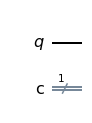

In [9]:
from qiskit import QuantumCircuit

# Fixing the number of qubits and the number of bits we want. Classical bits are used to store the information retrieved from the measurement of the Quantum Circuit.
num_qubits = 1
num_cls_bits = 1
# Making a container.
qc = QuantumCircuit(num_qubits, num_cls_bits)

# Visualizing it.
qc.draw('mpl')

Above, we have an empty container named q. No action has been performed on it yet. Lets use our val_to_angle function to manipulate its state to represent a value 3/4. For that, we need to rotate it from its initial state. Remember, the way we defined qubit suggests that for an angle $ \theta = 0 $, it will be in the state $ |0\rangle $, i.e., the 'off' state. We must rotate it towards the 'on' state. We use a rotation gate called the Pauli Rotation gate.

We shall apply Ry rotation gate upon the state of nth qubit in the circuit to rotate it by an angle theta such that it is in '3/4' on state. Why Ry gate? An Ry gate rotates the state of qubit in X-Z plane (rotation about Y axis). The states $ |0\rangle $ and $ |1\rangle $ are represented by + and - direction of the Z axis respectively. These are generally the computational basis states in quantum computing. An Ry operation on a fresh qubit rotates its initial state $ |0\rangle $ such that it makes an angle $ \theta $ with Z axis after rotation. The measurement is also performed in Z-basis unless specified otherwise. Thus, the polar angle $ \theta $ holds a direct significance in the state of a qubit, which is manipulated by an Ry gate. For this reason, we generally use Ry gates. 

This technique of encoding a state by manipulating the polar angle of rotation is called the Angle Encoding. Lets see it in action.

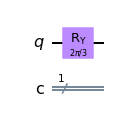

In [10]:
# defining the angle by with the qubit has to be rotated
theta = val_to_angle(3/4)

# rotating the 0th qubit by the angle theta to encode it via angle encoding
qc.ry(theta, 0)

# visualizing the circuit
qc.draw('mpl')

Lets digress briefly to visualize the state of a qubit using a Bloch Sphere. It represents the state $ |\psi\rangle $ by a vector originating at the center of the sphere and ending at the surface of the sphere.

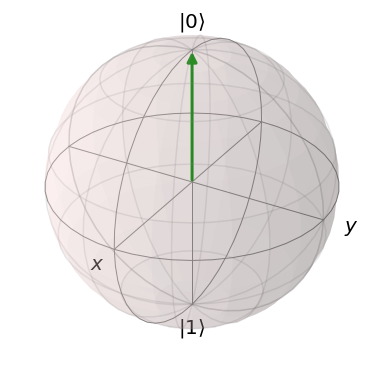

In [122]:
# importing the required libraries
import matplotlib.pyplot as plt
from qutip import Bloch
from math import pi, sin, cos

# defining a function to animate the Bloch sphere 
def plot_bloch_vector_spherical(theta, phi):
    b=Bloch()
    b.clear()
    
    # defining a vector in spherical coordinates to represent the qubit state, theta being the polar angle and phi being the phase
    vec=[sin(theta)*cos(phi), sin(theta)*sin(phi), cos(theta)]
    b.add_vectors(vec)
    return b.show()

# drawing an uninitialized qubit in the 0 state
plot_bloch_vector_spherical(0, 0)

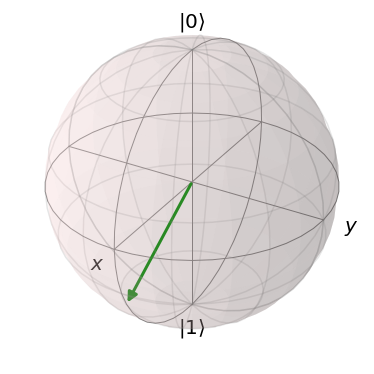

In [119]:
# state of qubit after being rotated by an angle theta
plot_bloch_vector_spherical(theta, 0)

It shows that the state of the qubit rotates in the X-Z plane. But the diagram reveals that theres a scope to rotate it in other planes as well. Moreover, we have been playing with another parameter 'phi' (that, being the second argument of the above function, was set to 0). It is called the phase of the qubit. Formally, the complete state of a qubit is given as, $$ |\psi\rangle = cos\frac{\theta}{2}|0\rangle + e^{i\phi}sin\frac{\theta}{2}|1\rangle. $$ The parameter $ \phi $ lets the qubit explore all possible states.  The gates Rx and Rz are used for this purpose as they rotate the state of a qubit about X and Z axis. Lets visualize it using the Bloch Sphere representation and rotate the phase of qubit by an angle $ \frac{\pi}{4} $ which has already been acted upon by an Ry gate for a $ \frac{\pi}{2} $ rotation.

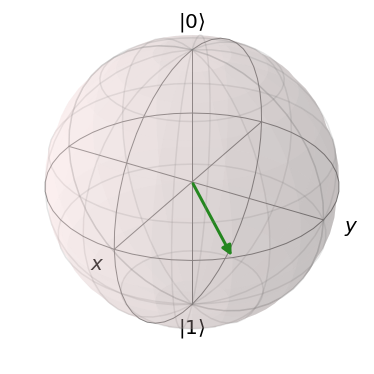

In [133]:
plot_bloch_vector_spherical(pi/2, pi/4)

Note that the qubit was rotated by an angle $ \frac{\pi}{2} $ after which its state lied parallel to the positive X axis, then a phase rotation by an angle $ \frac{\pi}{4} $ put it in the final state as shown.

Nevertheless, going back to the angle encoded qubit, we have a tiny quantum circuit and we need a way to simulate it.In Qiskit, Aer is a high-performance simulator framework for quantum circuits. It provides various backends that allow you to simulate the behavior of quantum circuits on classical computers. Aer offers different types of simulators, including statevector simulators, unitary simulators, and noisy simulators. The execute function is used to run quantum circuits on either a simulator or a real quantum device.

{'1': 75130, '0': 24870}


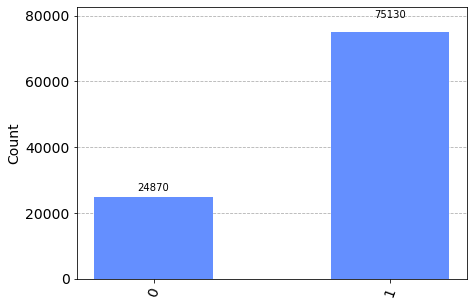

In [24]:
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram

# measuring 0th  qubit and storing its state in 0th classical bit
qc.measure(0,0)

# getting a backend from Aer to simulate the quantum circuit
backend = Aer.get_backend('qasm_simulator')

# executing the qc with backend
# we choose shots = 1000, quantum mechanics is probabilistic, one shot corresponds to one measurement of the circuit
# we measure it multiple times to get an idea of where it saturates
results = execute(qc, backend, shots = 100000).result()

# we get the count of results, i.e., the count of the number of times the circuit was measured as 0 or 1 
counts = results.get_counts()

print(counts)

plot_histogram(counts)

The counts we obtained are in correspondence with the encoding scheme. The probability of getting 1 is:

In [14]:
prob_1 = counts['1']/(counts['0'] + counts['1'])

prob_1

0.75074

This is almost equal to the value the qubit was encoded with, i.e., $\frac{3}{4}$. "Almost" because we always deal with probabilities in quantum computing. Now, lets encode an array of qubits to represent all the 6 features of a dataset.

In [49]:
num_qubits= 6

# create quantum circuit
qc1 = QuantumCircuit(num_qubits)

print("The first data instance: \n{}\n\n".format(X_train[0]))

# encoding the feature values
theta_val = list(map(lambda item: val_to_angle(item), X_train[0]))

print("The first data instance after being transformed to be fed to the qubits: \n{}".format(theta_val))

The first data instance: 
[0.11495611 0.27215369 0.29420206 0.51477828 0.51835959 0.49471461]


The first data instance after being transformed to be fed to the qubits: 
[0.6918175926715661, 1.0976461675913045, 1.1465918651851292, 1.6003571875245484, 1.6075237562615812, 1.5602253510857418]


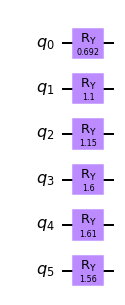

In [50]:
# using these values as angles to encode the qubit state
for qubit_number in range(6):
    
    # rotation each qubit using Ry gate by an angle 
    qc1.ry(theta_val[qubit_number], qubit_number)
    
# visualizing 
qc1.draw('mpl')

Now we have a state, which can be transformed however we desire by applying appropriate operations. This resembles the input layer of a neural network. Upon this, we need to apply a structure similar to parameterized hidden layers in Neural Networks. In quantum circuit, we call such a circuit the Parameterized Quantum Circuit or the Ansatz. An ansatz consists of multiple layers and each layer has two parts. The first part consists of a parameterized rotation gates being applied to each qubit. The rotation gates are no longer limited to Ry gates. We shall use Rx and Rz as well to allow the qubit to exlore all the states. The second part entangles all the qubits together. The entangling gates are not one qubit operations. They are multi-qubit operations in which the state of one or more qubits control the state of the target qubit. The qubit after being acted upon by Rx and Rz gate entangles more strongly as the correlations are then developed accordingly. First lets apply the first part of Ansatz.

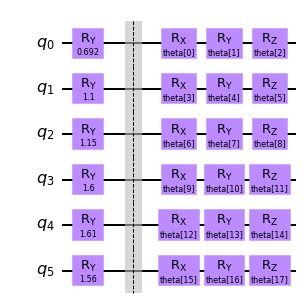

In [51]:
# first we define a parameter vector
from qiskit.circuit import ParameterVector

# for 6 qubits, we need 6 times 3 parameters to parameterize the rotation gates
num_parameters = 6*3
theta_vector = ParameterVector('theta', num_parameters)

index = 0

# we apply a barrier which is just a tool to visualize the separation of one component of the Quantum Circuit from the other, it performs no operation on the quantum state
qc1.barrier()

for num_qubit in range(6):
    
    qc1.rx(theta_vector[index], num_qubit)
    qc1.ry(theta_vector[index+1], num_qubit)
    qc1.rz(theta_vector[index+2], num_qubit)
    
    index = index+3
    
qc1.draw('mpl')

Now we have a input state being acted upon by rotation gates but there are no relations between any 2 qubits. Yet. Now we shall apply the second part of a layer of Ansatz. The entangling layer. We use 2 qubit CX (controlled not) gates to entangle 2 qubits. Firstly, a not gate (X gate) is the one which flips the state of a qubit. For example, $$ X|0\rangle = |1\rangle $$ So, a controlled not gate (CX gate) transforms in the following way. 

$$ CX|\alpha\rangle \otimes |\psi\rangle = |\alpha\rangle \otimes X^{\alpha}|\psi\rangle $$ 

Here, $ \alpha $ is the control qubit and $ \psi $ is the target qubit. For $ |\alpha\rangle = a|0\rangle + b|1\rangle $ and $ |\psi\rangle = c|0\rangle + d|1\rangle $ 

Note that the two qubits with states $ \alpha $ and $ \psi $ are the part of a same circuit and CX gate is applied on that circuit (or a subset of qubits in that circuit). This implies, we represented the state of the circuit by the Kronecker product of individual qubit states, generally called the outer product or the tensor product. A qubit is mathematically represented by a column vector. $$ |\alpha\rangle = \begin{pmatrix} a \\ b \end{pmatrix} $$ where the basis states are $$ |0\rangle = \begin{pmatrix} 1 \\ 0 \end{pmatrix}, |1\rangle = \begin{pmatrix} 0 \\ 1 \end{pmatrix}. $$ So a qubit is a 2D vector in a 'Hilbert Space', a hypothetical vectorspace containing all the complex vectors. The state of a circuit with $n$ qubits lie in a $2^n$ dimensional Hilbert Space because each dimension specifies the amplitude of the basis state in a superposition of all states. A tensor product of two $2 \times 1$ column vectors is a $4 \times 1$ column vector which completely specifies the state of the circuit. A $n$ qubit circuit would have $n-1$ tensor products of individual qubit states to represent a complete circuit. We can't use a general matrix product as the dimensions in the matrix products of matrices of the same order is conserved. So, the CX gate operation is as follows.

$$ CX|\alpha\rangle \otimes |\psi\rangle = (a|0\rangle + b|1\rangle) \otimes X^{\alpha}(c|0\rangle + d|1\rangle) $$

$$ CX|\alpha\rangle \otimes |\psi\rangle = ac|0\rangle X^0 |0\rangle + ad|0\rangle X^0 |1\rangle + bc|1\rangle X^1 |0\rangle + bd |1\rangle X^1 |1\rangle$$ 

$$ CX|\alpha\rangle \otimes |\psi\rangle = ac|0\rangle|0\rangle + ad|0\rangle|1\rangle + bc|1\rangle|1\rangle + bd |1\rangle|0\rangle$$ 

Adding and subtract $ bc|1\rangle|0\rangle $ and $ bd |1\rangle|1\rangle $

$$ CX|\alpha\rangle \otimes |\psi\rangle = ac|0\rangle|0\rangle + ad|0\rangle|1\rangle + bc|1\rangle|0\rangle - bc|1\rangle|0\rangle + bc|1\rangle|1\rangle + bd |1\rangle|0\rangle + bd |1\rangle|1\rangle - bd |1\rangle|1\rangle$$

Rearranging,

$$ CX|\alpha\rangle \otimes |\psi\rangle = ac|0\rangle|0\rangle + ad|0\rangle|1\rangle + bc|1\rangle|0\rangle + bd |1\rangle|1\rangle - bc|1\rangle|0\rangle + bc|1\rangle|1\rangle + bd |1\rangle|0\rangle - bd |1\rangle|1\rangle$$ 

$$ CX|\alpha\rangle \otimes |\psi\rangle = (a|0\rangle + b|1\rangle) \otimes (c|0\rangle + d|1\rangle) - bc|1\rangle|0\rangle + bc|1\rangle|1\rangle + bd |1\rangle|0\rangle - bd |1\rangle|1\rangle$$ 

$$ CX|\alpha\rangle \otimes |\psi\rangle = |\alpha\rangle \otimes |\psi\rangle - bc|1\rangle|0\rangle + bc|1\rangle|1\rangle + bd |1\rangle|0\rangle - bd |1\rangle|1\rangle$$ 

This is a depiction of correlations that are developed by entangling the qubits. Now lets apply two qubit CX gates to entangle each qubit.

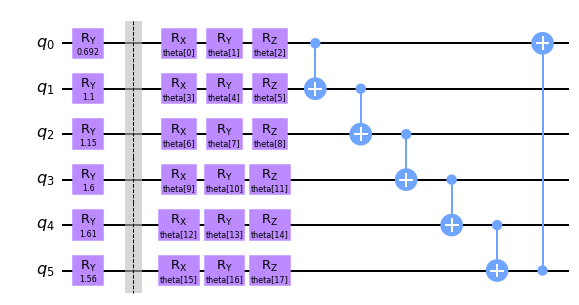

In [52]:
for num_qubit in range(6-1):
    # entangling the consecutive qubits
    qc1.cx(num_qubit, num_qubit+1)

qc.barrier()

qc1.draw('mpl')

Now we have a Quantum Circuit with qubits encoded using input data and an Ansatz with 1 layer consisiting of rotation and entangling layer. We have a library in qiskit which can provide us an ansatz with various rotation and entangling schemes. We can append that Ansatz circuit to the encoded data structure.

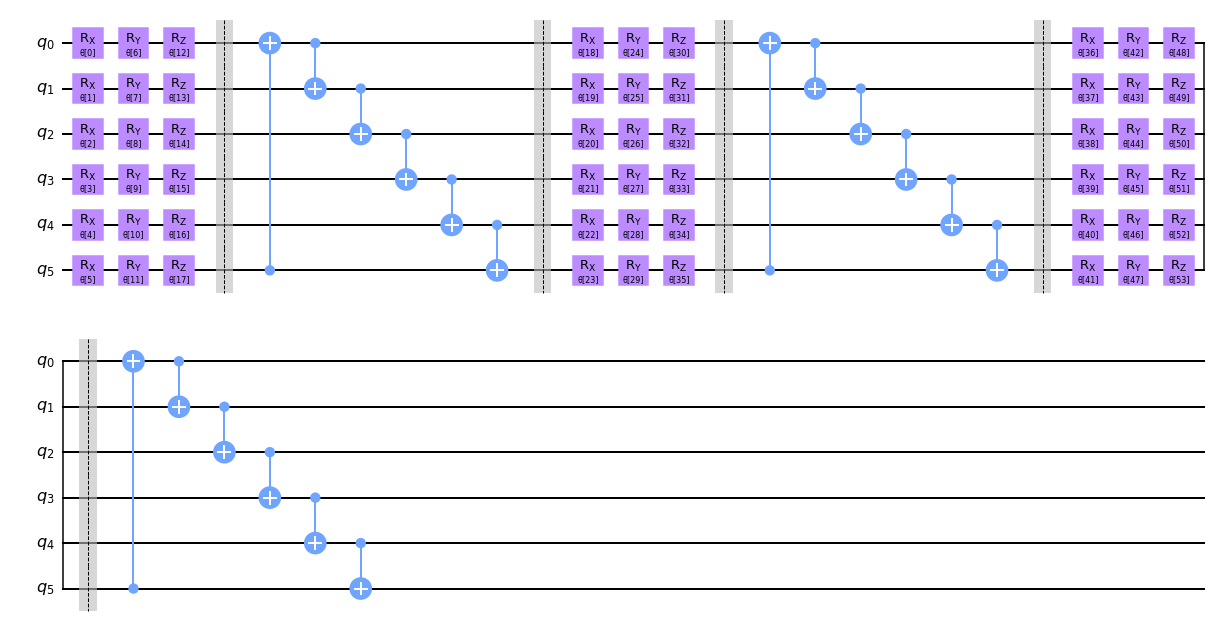

In [69]:
# importing PQC
from qiskit.circuit.library import TwoLocal


rotation_gates = ['rx', 'ry', 'rz']
entangling_gates = 'cx'
entangling_scheme = 'linear'
num_layers = 3

Linear_Ansatz = TwoLocal(6, rotation_gates, entangling_gates, entangling_scheme, reps = num_layers, skip_final_rotation_layer = True, insert_barriers = True)
Linear_Ansatz.name = 'Linear Ansatz'

# visualizing
Ansatz.decompose().draw('mpl')

The entangling scheme 'linear' is an equivalent of the 'Nearest Neighbor' entangling circuit in qiskit. This type of circuit is implemented on a quantum devices with a linear array of qubits in which its feasible to entangle two consecutive qubits. This circuit has a low depth as the entangling capability is low. Low in comparison to what? A 'Circuit Block' entangling circuit. It consists of a circular arrangement of qubits. Unlike the Nearest Neighbor circuit, it entangles the first and the last qubit as well. An equivalent of this in qiskit is the 'circular' entangling scheme. It has a higher depth and quite intuitively, higher entangling capability. 'All to All' entangling circuits are the deepest with all qubits entangled with each other. It is possible on the devices with qubits with high interconnectivity. It has the most entangling capacity and expressivity. Expressivity here refers to the class of function the Ansatz can approximate.

Here's a depiction of circular/Circuit Block entangling circuit.

In [ ]:
rotation_gates = ['rx', 'ry', 'rz']
entangling_gates = 'cx'
entangling_scheme = 'circular'
num_layers = 3

Circular_Ansatz = TwoLocal(6, rotation_gates, entangling_gates, entangling_scheme, reps = num_layers, skip_final_rotation_layer = True, insert_barriers = True)
Circular_Ansatz.name = 'Circular Ansatz'

# visualizing
Ansatz.decompose().draw('mpl')

The 'All to All' entangling scheme has the equivalent called the 'full' entangling scheme in qiskit.

In [ ]:
rotation_gates = ['rx', 'ry', 'rz']
entangling_gates = 'cx'
entangling_scheme = 'Full Ansatz'
num_layers = 3

Full_Ansatz = TwoLocal(6, rotation_gates, entangling_gates, entangling_scheme, reps = num_layers, skip_final_rotation_layer = True, insert_barriers = True)
Full_Ansatz.name = 'Ansatz'

# visualizing
Ansatz.decompose().draw('mpl')

The choice of entangling scheme depends upon the complexity of task. All to all encoding is hard to achieve in real devices. Nevertheless, we shall begin our task with the 'Full_Ansatz' for demonstration.

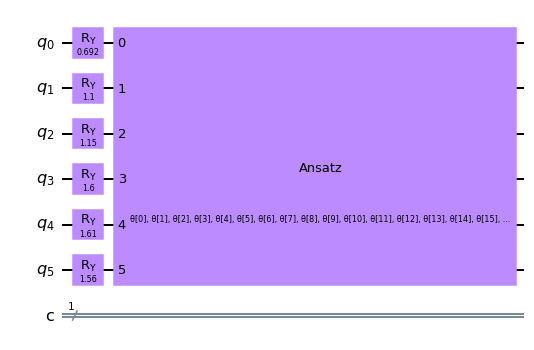

In [77]:
# make a new quantum circuit for data
qc2 = QuantumCircuit(6,1)

for qubit_number in range(6):
    
    # rotation each qubit using Ry gate by an angle 
    qc2.ry(theta_val[qubit_number], qubit_number)
    
# defining the string of qubit indices to which the Ansatz has to be appended
string_indices = [i for i in range(6)]

qc.barrier()

# appending the above ansatz to the Quantum Circuit
qc2.append(Full_Ansatz, string_indices)

# visualizing
qc2.draw('mpl')

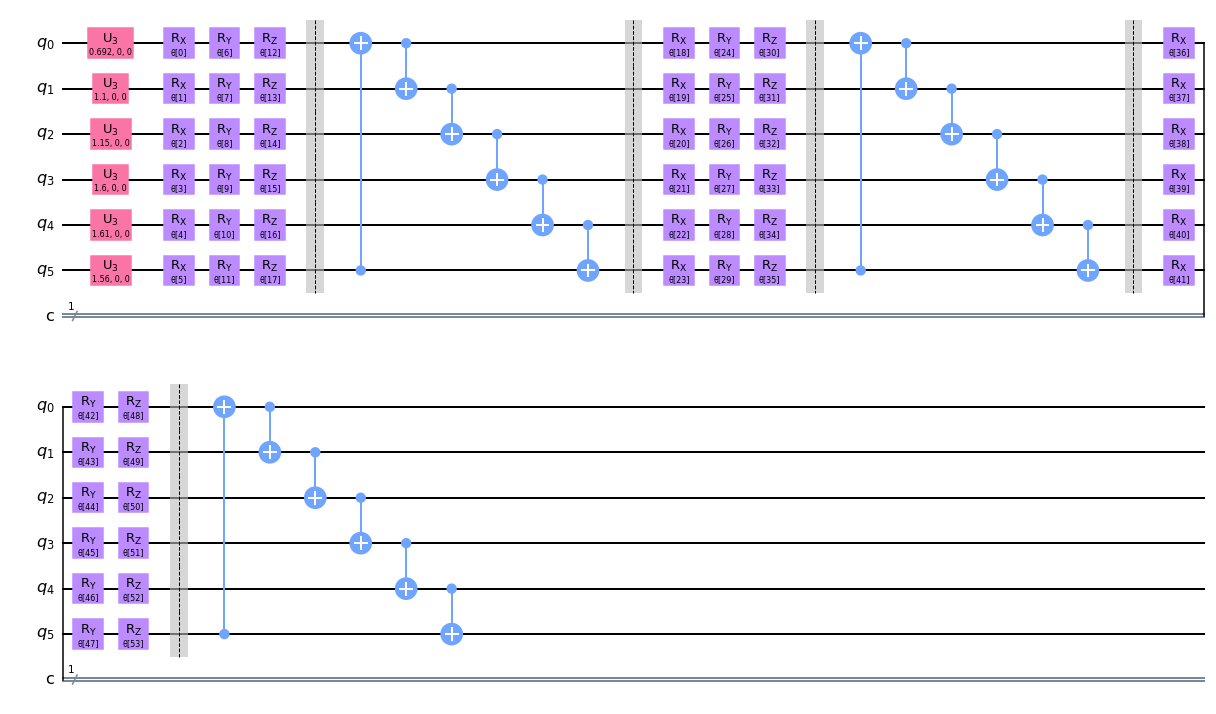

In [78]:
# detailed view of Ansatz
qc2.decompose().decompose().draw('mpl')

Now we have encode the data in the qubits and then applied a parameterized circuit. The state at the end is a function of parameters. It resembles a Neural Network with input layer and hidden layers. The last step is measuring the state of a qubit. Our task is binary classification. We measure only one qubit for two reasons. First, more the number of qubits are measured, more is the error in measurement on a real quantum device. Second, measuring more number of qubits pushes us in a Barren Plateau. Barren Plateaus are the regions which arise while using gradient based optimizers. The gradient here reduces exponentially, making it hard for them to converge to a global minima. So we avoid measuring multiple qubits (However, we would use gradient free optimizers for optimization to avoid the second problem). But first, we need to bind the real values with the Quantum Circuit in place of parameters. The parameters are:

In [79]:
qc2.parameters

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15]), ParameterVectorElement(θ[16]), ParameterVectorElement(θ[17]), ParameterVectorElement(θ[18]), ParameterVectorElement(θ[19]), ParameterVectorElement(θ[20]), ParameterVectorElement(θ[21]), ParameterVectorElement(θ[22]), ParameterVectorElement(θ[23]), ParameterVectorElement(θ[24]), ParameterVectorElement(θ[25]), ParameterVectorElement(θ[26]), ParameterVectorElement(θ[27]), ParameterVectorElement(θ[28]), ParameterVectorElement(θ[29]), ParameterVectorElement(θ[30]), ParameterVectorElement(θ[31]), Par

So, there are 54 parameters, lets bind them.

In [80]:
import numpy as np

# defining random parameters
parameters = np.random.rand(54)

# making a dictionary with a parameter as key and a numeric value as the value to be bound
parameters_dictionary = dict(zip(qc2.parameters, parameters))

# binding these parameters with quantum circuit
qc2 = qc2.bind_parameters(parameters_dictionary)

# after binding, the circuit should have no parameters
qc2.parameters

ParameterView([])

Now we are ready to measure the state of a qubit, say qubit 0. We shall again use the 'qasm_simulator' as backend to simulate the circuit.

In [83]:
# measuring the 0th qubit and storing the state in 0th classical bit
qc2.measure(0,0)

# defining backend
backend = Aer.get_backend('qasm_simulator')

# executing the circuit
results = execute(qc2, backend, shots = 1000).result()

# measuring the counts of 0 and 1
counts = results.get_counts()

print(counts)

{'1': 437, '0': 563}


So the probabilities of class 0 and class 1 are given as:

In [84]:
print(f"The probabilities of class 0 is {counts['0']/(counts['0'] + counts['1'])}.\nThe probability of class 1 is {counts['1']/(counts['0'] + counts['1'])}.")

The probabilities of class 0 is 0.563.
The probability of class 1 is 0.437.


Now we can construct a neural network.

In [98]:
import time 
# defining a function to encode data
def encoder(input_size, circuit, sample, dataset):
    
    # extracting the data instance at the index 'sample'
    val = dataset[sample][0:6]
    
    # turning the feature values to angle (angle encoding)
    val = list(map(lambda item: val_to_angle(item), val))
    
    # defining a circuit to encode data
    encoder_circuit = QuantumCircuit(input_size)
    
    # encoding the state of each qubit
    for i in range(input_size):
        encoder_circuit.ry(val[i], i)
    
    # appending encoder circuit to mother circuit
    circuit.append(encoder_circuit, [k for k in range(input_size)])
    
    return circuit

In [169]:
# defining a function to construct an Ansatz
def ansatz(input_size, circuit, layers, params):
    
    # defining an ansatz
    qnn = TwoLocal(input_size, ['rx', 'ry', 'rz'], 'cx', 'full', reps = layers, skip_final_rotation_layer = True, insert_barriers = True)
    
    # appending ansatz to mother circuit
    circuit.append(qnn, [k for k in range(input_size)])
        
    return circuit

In [182]:
# defining a function to predict the state
def predict(params):
    
    # an empty list to store predictions
    predictions = []
    
    # noting the runtime of circuit
    start = time.time()
    
    for sample in range(len(X_train)):
        
        # constructing quantum circuit
        qc = QuantumCircuit(6,1)
        encoder(6, qc, sample, X_train)
        ansatz(6, qc, 5, params)
        
        qc = qc.bind_parameters(dict(zip(qc.parameters, params)))
    
        # measuring the first qubit
        qc.measure(0,0)

        # executing the circuit
        results = execute(qc, Aer.get_backend('qasm_simulator'), shots = 1000).result().get_counts()
        
        # predicting
        pred = results['1']/1000
        
        # appending prediction
        predictions.append(pred)    
            
    end = time.time()
    duration = end-start
    print(f"The runtime of the circuit is {duration}.\n\n")
    
    return predictions, Y_train

In [175]:
# predicting using random parameters
predictions, labels = predict(np.random.rand(90))

The runtime of the circuit is 41.528067111968994.




In [153]:
# We have successfully predicted using Quantum Neural Network.
print("The predictions and labels are:\n")
list(zip(predictions, labels))

The predictions and labels are:



[(0.392, 0.0),
 (0.357, 0.0),
 (0.463, 0.0),
 (0.357, 0.0),
 (0.412, 0.0),
 (0.471, 1.0),
 (0.389, 0.0),
 (0.384, 0.0),
 (0.468, 0.0),
 (0.438, 0.0),
 (0.405, 0.0),
 (0.414, 0.0),
 (0.49, 1.0),
 (0.511, 1.0),
 (0.49, 1.0),
 (0.416, 0.0),
 (0.444, 0.0),
 (0.506, 1.0),
 (0.351, 0.0),
 (0.529, 1.0),
 (0.426, 0.0),
 (0.359, 0.0),
 (0.358, 0.0),
 (0.396, 0.0),
 (0.462, 1.0),
 (0.404, 0.0),
 (0.374, 0.0),
 (0.554, 1.0),
 (0.346, 0.0),
 (0.402, 0.0),
 (0.382, 0.0),
 (0.548, 1.0),
 (0.384, 0.0),
 (0.539, 1.0),
 (0.524, 1.0),
 (0.36, 0.0),
 (0.395, 0.0),
 (0.43, 0.0),
 (0.458, 1.0),
 (0.396, 0.0),
 (0.359, 0.0),
 (0.468, 0.0),
 (0.33, 0.0),
 (0.453, 1.0),
 (0.398, 0.0),
 (0.426, 0.0),
 (0.396, 0.0),
 (0.388, 0.0),
 (0.33, 0.0),
 (0.449, 1.0),
 (0.434, 0.0),
 (0.515, 1.0),
 (0.531, 1.0),
 (0.401, 0.0),
 (0.402, 0.0),
 (0.513, 1.0),
 (0.386, 0.0),
 (0.338, 0.0),
 (0.415, 0.0),
 (0.459, 0.0),
 (0.395, 0.0),
 (0.377, 0.0),
 (0.407, 0.0),
 (0.477, 1.0),
 (0.488, 1.0),
 (0.572, 1.0),
 (0.403, 0.0),
 

Now we are left with optimizing the parameters to get the optimized predictions. Lets start by defining an objecive function that must be minimized.

In [178]:
import tensorflow as tf
from IPython.display import clear_output

def Measurement_Based_Cost_Function(params):

    true_label, pred = predict(params)
    true_label = np.array(true_label).astype('float32')
    pred = np.array(pred).astype('float32')
    
    # a natural choice of loss function for binary classification is Binary Cross Entropy, however, with a QNN, we're trying to make a QNN which predicts 1 with a probability above 0.5 for a '1' prediction and below 0.5 for a '0' prediction, so we shall continue with the MSE loss function.
    mse = tf.keras.losses.MeanSquaredError()
    loss = mse(true_label, pred).numpy()
    cost = loss

    # we shall visualize the loss at each iteration 
    clear_output(wait=True)
    objective_func_vals.append(cost)
    print(f"Loss after {len(objective_func_vals)} iterations is {loss}.\nMin loss is {min(objective_func_vals)}.\n")
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

We shall now use a gradient free optimizer SPSA, Simultaneous Perturbation Stochastic Aprroximation, for optmization. It is based on the finite difference method for the calculation of gradients. It calculates the function value at 2 points and then those vaules and those 2 points are used to estimate the gradient.

Loss after 251 iterations is 0.1231086328625679.
Min loss is 0.1231086328625679.



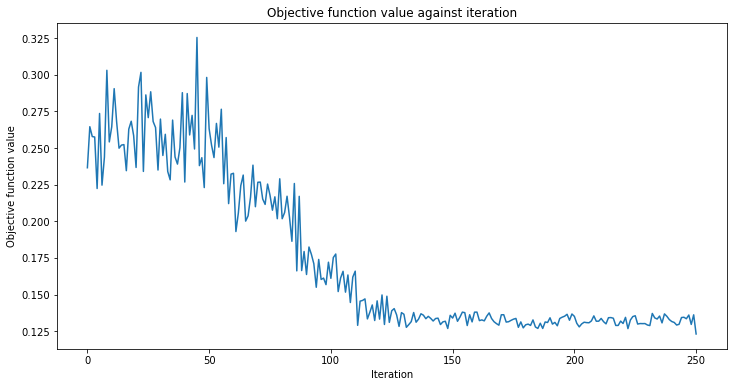

Optimized parameters are:

 [-0.03669514  0.38085368 -0.66153365  1.38726875 -0.27513419  1.84001799
  0.28699332  1.64183431  0.81645313 -0.98890241  0.16226821 -0.45903659
  0.58922253  0.30663187 -1.98748922  1.694271   -1.25822202  0.9932057
 -0.00368979  0.47426846 -0.07022066  1.82310946  0.80893309 -0.57647657
  0.00886289  1.65296985 -0.21263684  0.43757416  0.37773783  2.13158536
  2.69672782  0.34970995  1.32372033  1.41871335 -0.40094273  1.08205212
  0.02878441  0.60885286  1.57133502  1.02703766  0.52395953  0.59229648
  0.01636919  1.28580775  0.39654449 -0.29441817  0.47386524  1.07144386
  1.24301801  1.30187533  0.33469277  2.09327587 -0.8766948  -0.64687012
  0.0103794   1.1320137   0.70653617 -0.39760411  1.37451314 -0.38919733
 -0.05080476 -0.18468484  0.3642388   0.24250424  0.42696437 -0.18560154
  1.53429701  1.04924757  0.22312979  1.91261535  0.1302534  -0.30622146
 -0.0148317  -1.03431336 -0.08750515  1.73522457  0.21131602  2.38776287
 -0.03435759  0.65361153

In [180]:
from qiskit.algorithms.optimizers import SPSA

start = time.time()

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

spsa = SPSA(maxiter=100)
result = spsa.minimize(Measurement_Based_Cost_Function, x0 = np.random.rand(90), bounds = (0,1))

optimized_params = result.x

print(f"Optimized parameters are:\n\n {optimized_params}.")

stop = time.time()
duration = stop-start
print(f"runtime is {duration}.")

In [181]:
# predicting the labels with the optimized parameters on the training and testing data
trainPred, trainLabels = predict(optimized_params)

The runtime of the circuit is 51.0425078868866.




In [183]:
testPred, testLabels = predict(optimized_params)

The runtime of the circuit is 110.296471118927.




In [184]:
# mapping the predictions to outputs

training = list(map(lambda item : 1.0 if item>0.5 else 0.0, trainPred))
testing = list(map(lambda item : 1.0 if item>0.5 else 0.0, testPred))

In [185]:
# making the confusion matrices

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cf_train = confusion_matrix(trainLabels, training)
cf_test = confusion_matrix(testLabels, testing)

In [191]:
classification_report_training_data = classification_report(trainLabels, training)
classification_report_testing_data = classification_report(testLabels, testing)

In [192]:
print(classification_report_training_data)

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91       108
         1.0       0.96      0.71      0.82        63

    accuracy                           0.88       171
   macro avg       0.91      0.85      0.87       171
weighted avg       0.89      0.88      0.88       171



In [194]:
print(classification_report_testing_data)

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       249
         1.0       0.98      0.68      0.80       149

    accuracy                           0.87       398
   macro avg       0.91      0.83      0.85       398
weighted avg       0.89      0.87      0.87       398



The results provide conclusive evidence about the power of QNNs. But the time complexity is an issue. It'd always be hard to simulate quantum processes on classical computers. Now, we have an idea about the benifits we can get from a QNN, we just need to wait for a reliable Quantum Computer to be built. 